# Double Pendulum Analysis Using NG‑RC

This notebook demonstrates the analysis of a double pendulum system using the Next Generation Reservoir Computing (NG‑RC) framework. 

**Objectives:**
- Simulate the dynamics of a double pendulum using numerical integration.
- Train an NG‑RC model (and/or compare predictions) on the simulation data.
- Visualize the results using various plots (time series, scatter comparisons, phase plots).
- Evaluate the model performance using error metrics (RMSE, MAE, R2, etc.).

The source code for models, NG‑RC processing, ODE solving, and plotting is organized in the `src` folder.


In [1]:
import sys
import os

# Add the project root directory to the Python path so that modules in the src folder can be imported.
sys.path.append(os.path.abspath('..'))

# Import required modules and classes
from src.models.double_pendulum import DoublePendulum
from src.ngrc.ngrc_model import ModelParameters, DatasetDiscretization, FeatureVector, compute_training_prediction, compute_testing_prediction, calculate_metrics
from src.utils.solver import simulate_dynamic_system
from src.utils.plot_helper import (
    plot_comparison, 
    plot_comparison_only_testing, 
    plot_scatter_comparison, 
    plot_phase_comparison, 
    plot_scatter_comparison_only_testing, 
    plot_phase_comparison_only_testing, 
    plot_W_out,
    get_feature_labels
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# (Optional) Update any additional matplotlib parameters if necessary
plt.rcParams.update({
    'font.size': 10,
    'lines.linewidth': 0.8,
    'figure.dpi': 300,
    'axes.grid': True,
})


## System Parameters and Initial Conditions

In this section, we set up the parameters for the double pendulum simulation. We define the physical parameters such as lengths, masses, and gravitational acceleration. We also specify the initial state of the system.


In [2]:
# Double Pendulum physical parameters
L1 = 1.0       # Length of first pendulum (meters)
L2 = 1.0       # Length of second pendulum (meters)
M1 = 1.0       # Mass of first pendulum (kg)
M2 = 1.0       # Mass of second pendulum (kg)
G = 9.81       # Gravitational acceleration (m/s^2)

# Initial state: [theta1, omega1, theta2, omega2]
th1, w1 = 60.0, 0.0
th2, w2 = 30.0, 0.0
initial_state = np.radians([th1, w1, th2, w2])

## Simulation of Dynamics

We now simulate the dynamics of the double pendulum using the ODE solver. The static method `double_pendulum_solve_ivp` from the `DoublePendulum` class is used together with our helper function `simulate_dynamic_system`.


In [3]:
# Define simulation parameters
dt = 0.01       # Time step in seconds
max_time = 100   # Total simulation time in seconds

# Simulate the double pendulum using the provided static method
# Note: The derivative function requires the parameters L1, L2, M1, M2, and G.
pendulum_states, time_array = simulate_dynamic_system(
    derivs_dynamic=DoublePendulum.double_pendulum_solve_ivp, 
    initial_state=initial_state, 
    params=(L1, L2, M1, M2, G), 
    dt=dt, 
    max_time=max_time
)


## NG‑RC Model Setup and Feature Engineering

In this section, we prepare the NG‑RC model. We first set the NG‑RC model parameters (such as the polynomial order, number of delay taps, and regularization) using the `ModelParameters` class. Next, we discretize the dataset (using the time array from the simulation) with the `DatasetDiscretization` class and build the feature vectors using the `FeatureVector` class.


In [5]:
# Define NG‑RC model parameters
model_params = ModelParameters(
    polynomial_order=3,
    input_dimension=4,
    delay_taps=3,
    include_constant=False,
    ridge_regression=1.0e-3
)

# Create dataset discretization (e.g., 80% training, 20% testing)
dataset_disc = DatasetDiscretization(
    model_params, 
    time_array, 
    train_percentage=45, 
    test_percentage=55
)

# Build the feature vector object for NG‑RC
feature_vec_obj = FeatureVector(
    model_params, 
    pendulum_states, 
    dataset_disc,
    including_all_pol_combination=True
)

# Build the linear and full feature vectors for training
linear_vector = feature_vec_obj.build_linear_feature_vector()
full_vector = feature_vec_obj.build_full_feature_vector(linear_vector)

## NG‑RC Training and Prediction

Now we compute the output weights using ridge regression and generate predictions for the training phase. We use the helper function `compute_training_prediction` for this purpose. Similarly, testing predictions are computed using `compute_testing_prediction`.


In [7]:
# Define indices for warm-up and training based on discretization
warmup = dataset_disc.warmup_pts()
warmup_train = dataset_disc.warmup_train_pts()
train_pts = dataset_disc.train_pts()
test_pts = dataset_disc.test_pts()
input_dim = model_params.input_dimension
ridge_param = model_params.ridge_regression

# Compute training predictions
W_out, X_predict = compute_training_prediction(linear_vector, full_vector, warmup, warmup_train, train_pts, input_dim, ridge_param)
y_true_train = linear_vector[0:input_dim, warmup:warmup_train]
y_pred_train = X_predict
t_train = time_array[warmup:warmup_train]

# Compute testing predictions
x_test = compute_testing_prediction(linear_vector, feature_vec_obj, W_out, warmup_train, test_pts, input_dim)
y_true_test = linear_vector[0:input_dim, warmup_train - 1:-1]
y_pred_test = x_test[0:input_dim, :]
t_test = time_array[warmup_train - 1:-1]

## Performance Evaluation and Visualization

We now compare the NG‑RC predictions with the numerical simulation data. We will use various plotting functions for:
- Time series comparisons.
- Scatter and phase comparisons.
- Visualizing the learned output weights.

Additionally, we calculate performance metrics (RMSE, MAE, R2, etc.) using the `calculate_metrics` function.


In [9]:
total_variance = pendulum_states.var(axis=1).sum()
metrics_train = calculate_metrics(y_true_train, y_pred_train, total_variance)
metrics_test = calculate_metrics(y_true_test, y_pred_test, total_variance)

metrics_df = pd.DataFrame({
    "Fase": ["Treinamento", "Teste"],
    "RMSE": [metrics_train["RMSE"], metrics_test["RMSE"]],
    "NRMSE": [metrics_train["NRMSE"], metrics_test["NRMSE"]],
    "MAE": [metrics_train["MAE"], metrics_test["MAE"]],
    "R²": [metrics_train["R2"], metrics_test["R2"]],
    "MAPE (%)": [metrics_train["MAPE (%)"], metrics_test["MAPE (%)"]]
})
print("\nMétricas de desempenho:")
print(metrics_df.to_string())


Métricas de desempenho:
          Fase      RMSE     NRMSE       MAE        R²   MAPE (%)
0  Treinamento  0.000094  0.000035  0.000055  1.000000   0.032393
1        Teste  0.240624  0.088961  0.149311  0.965085  60.572776


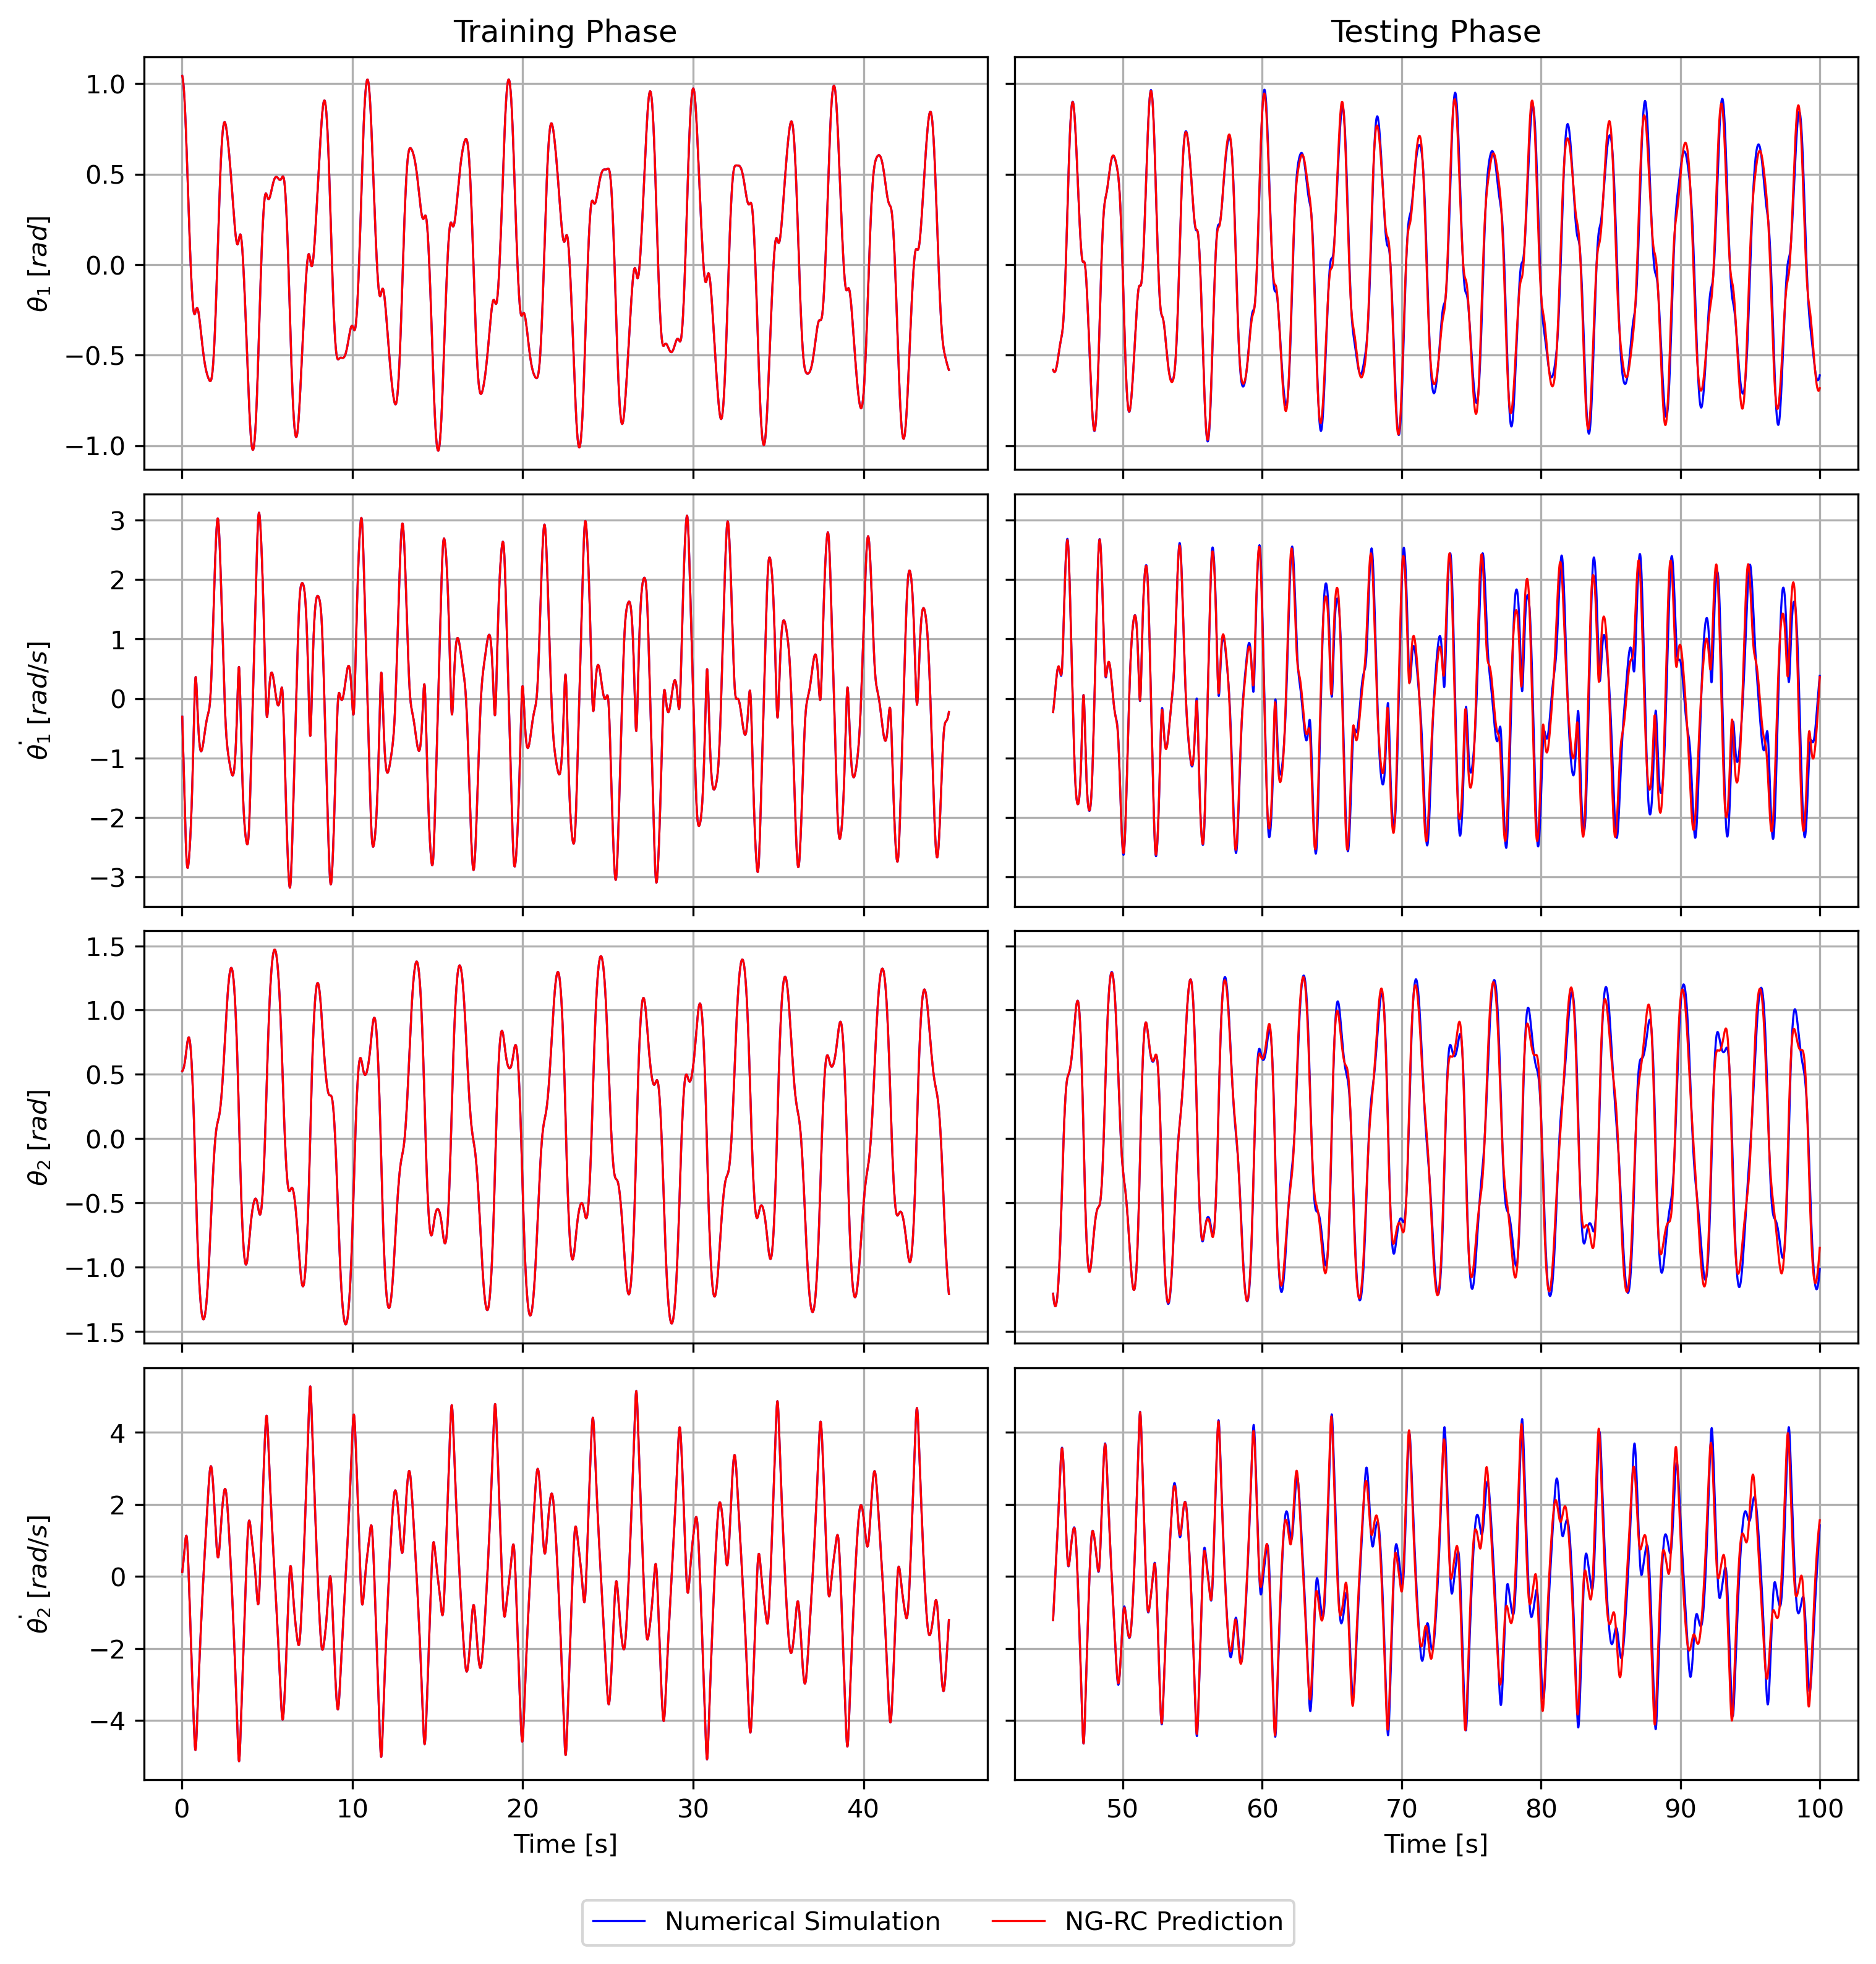

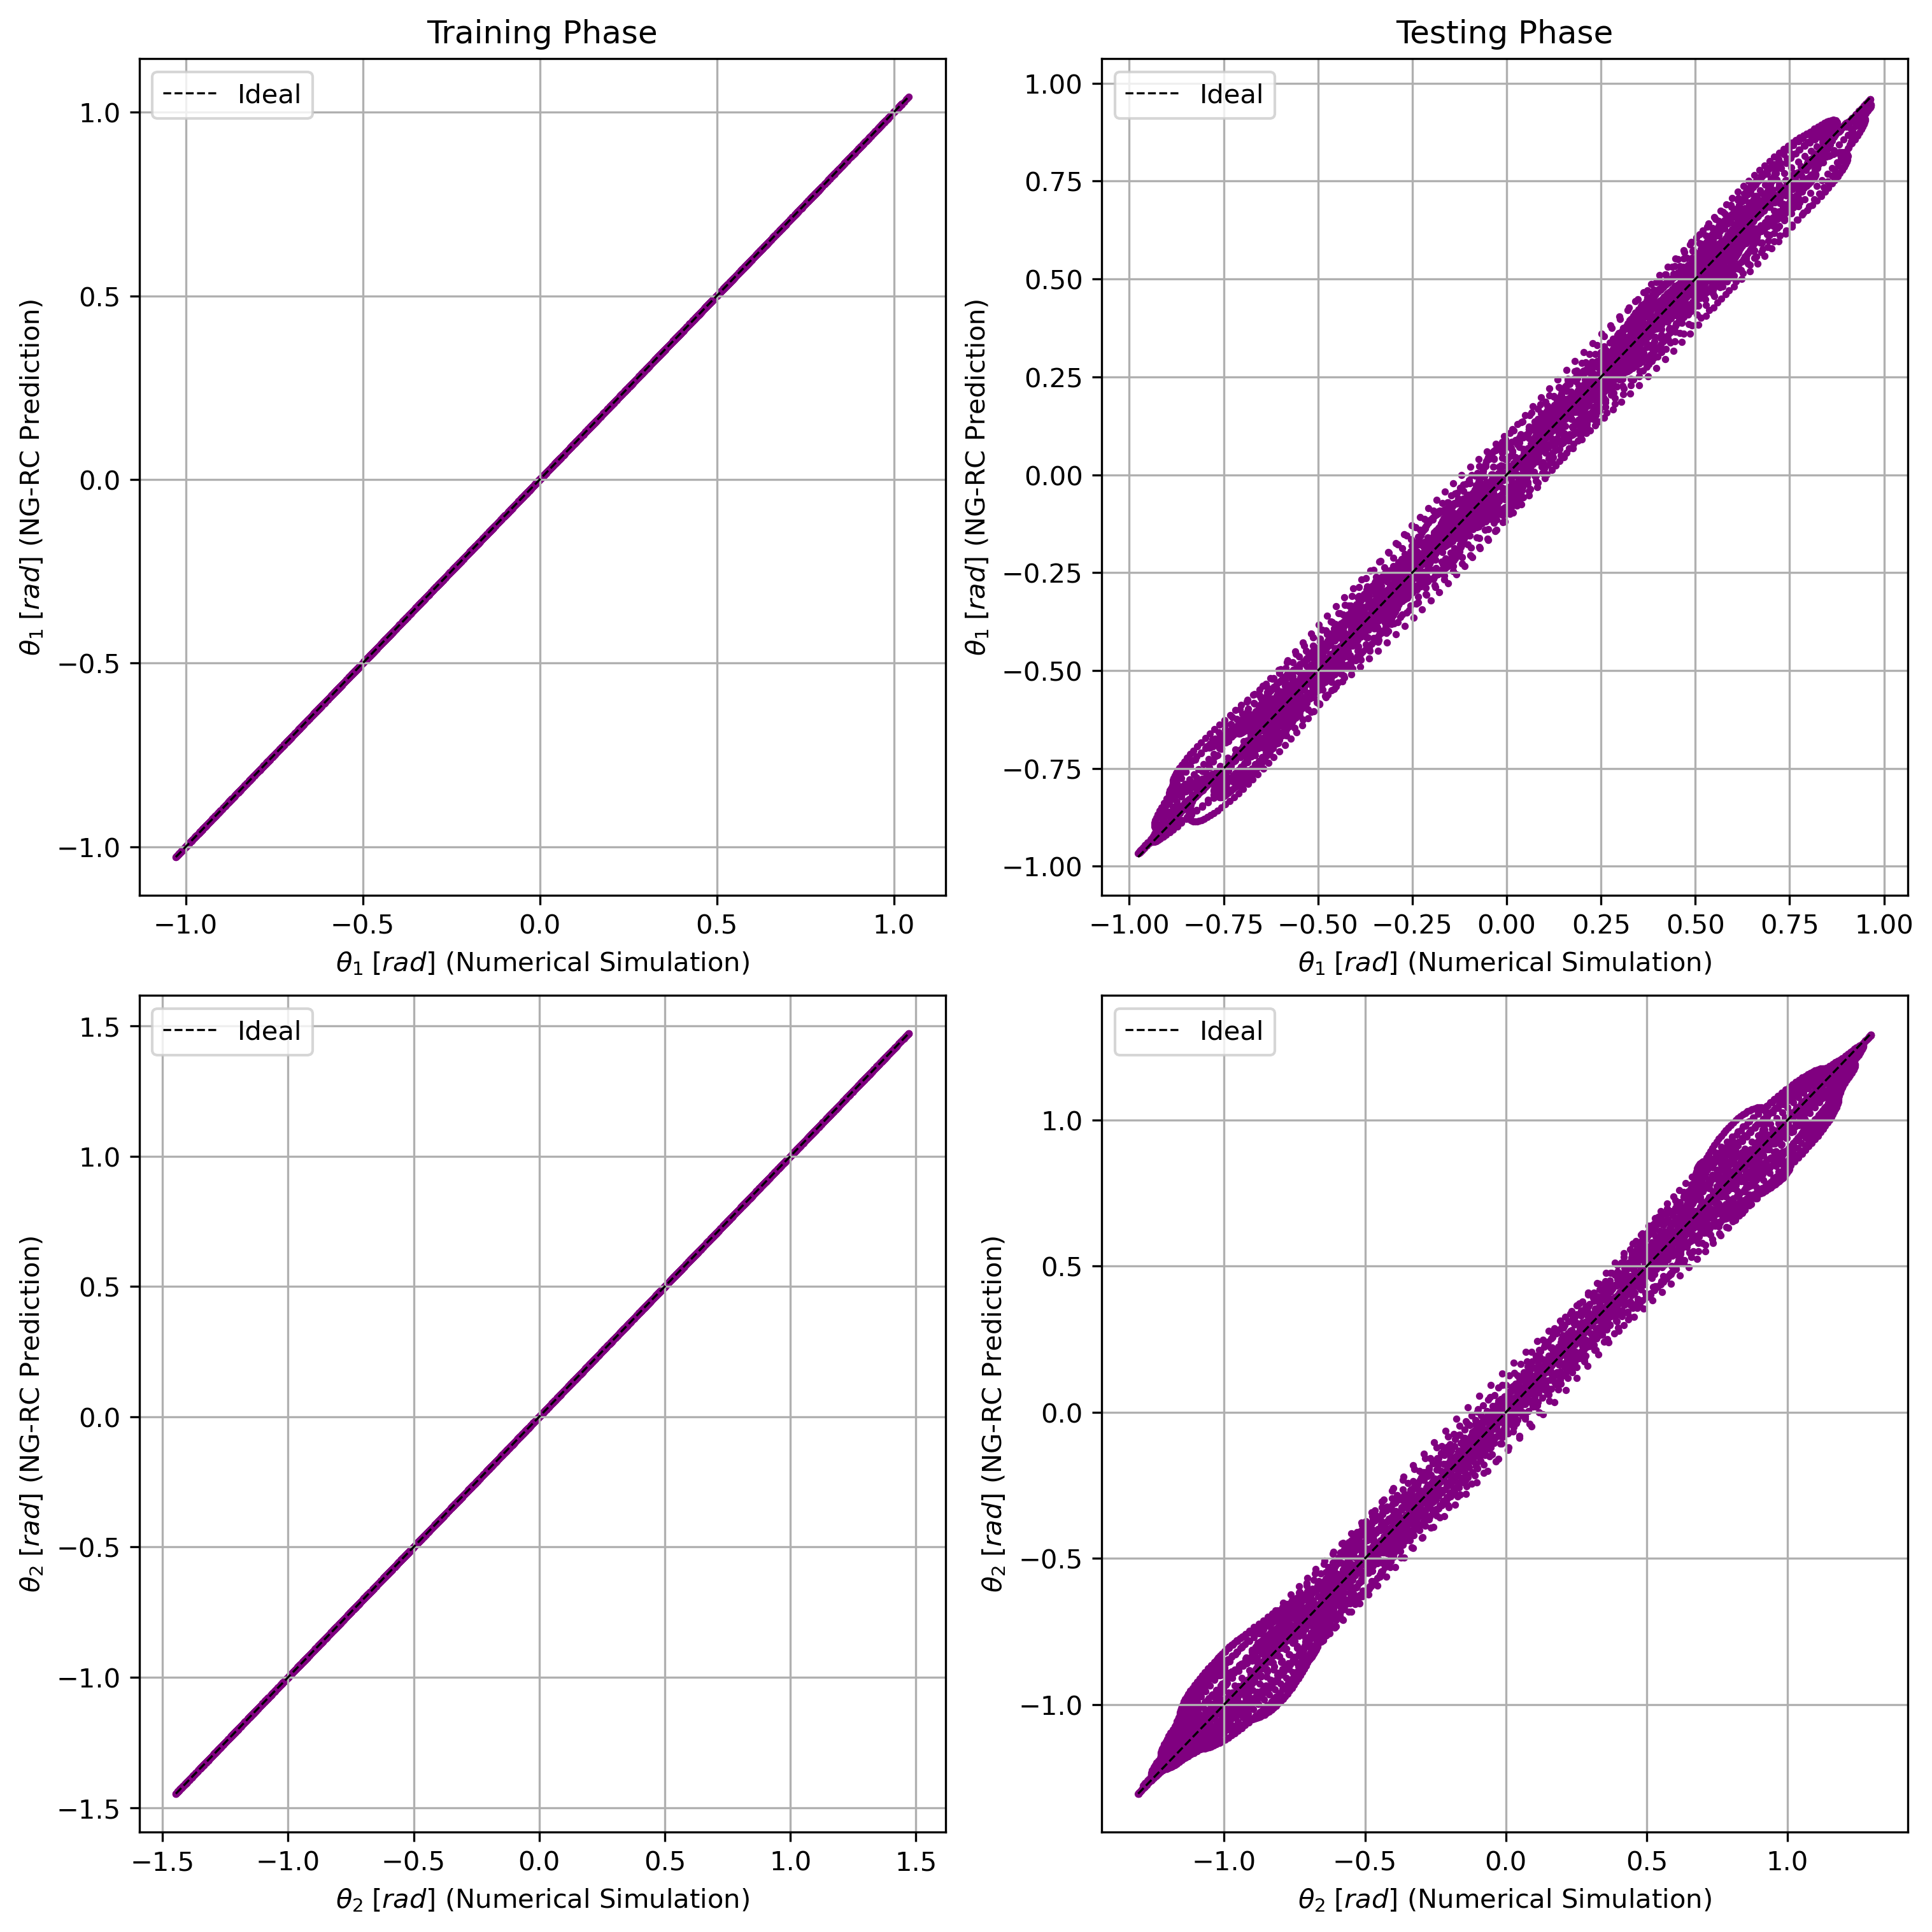

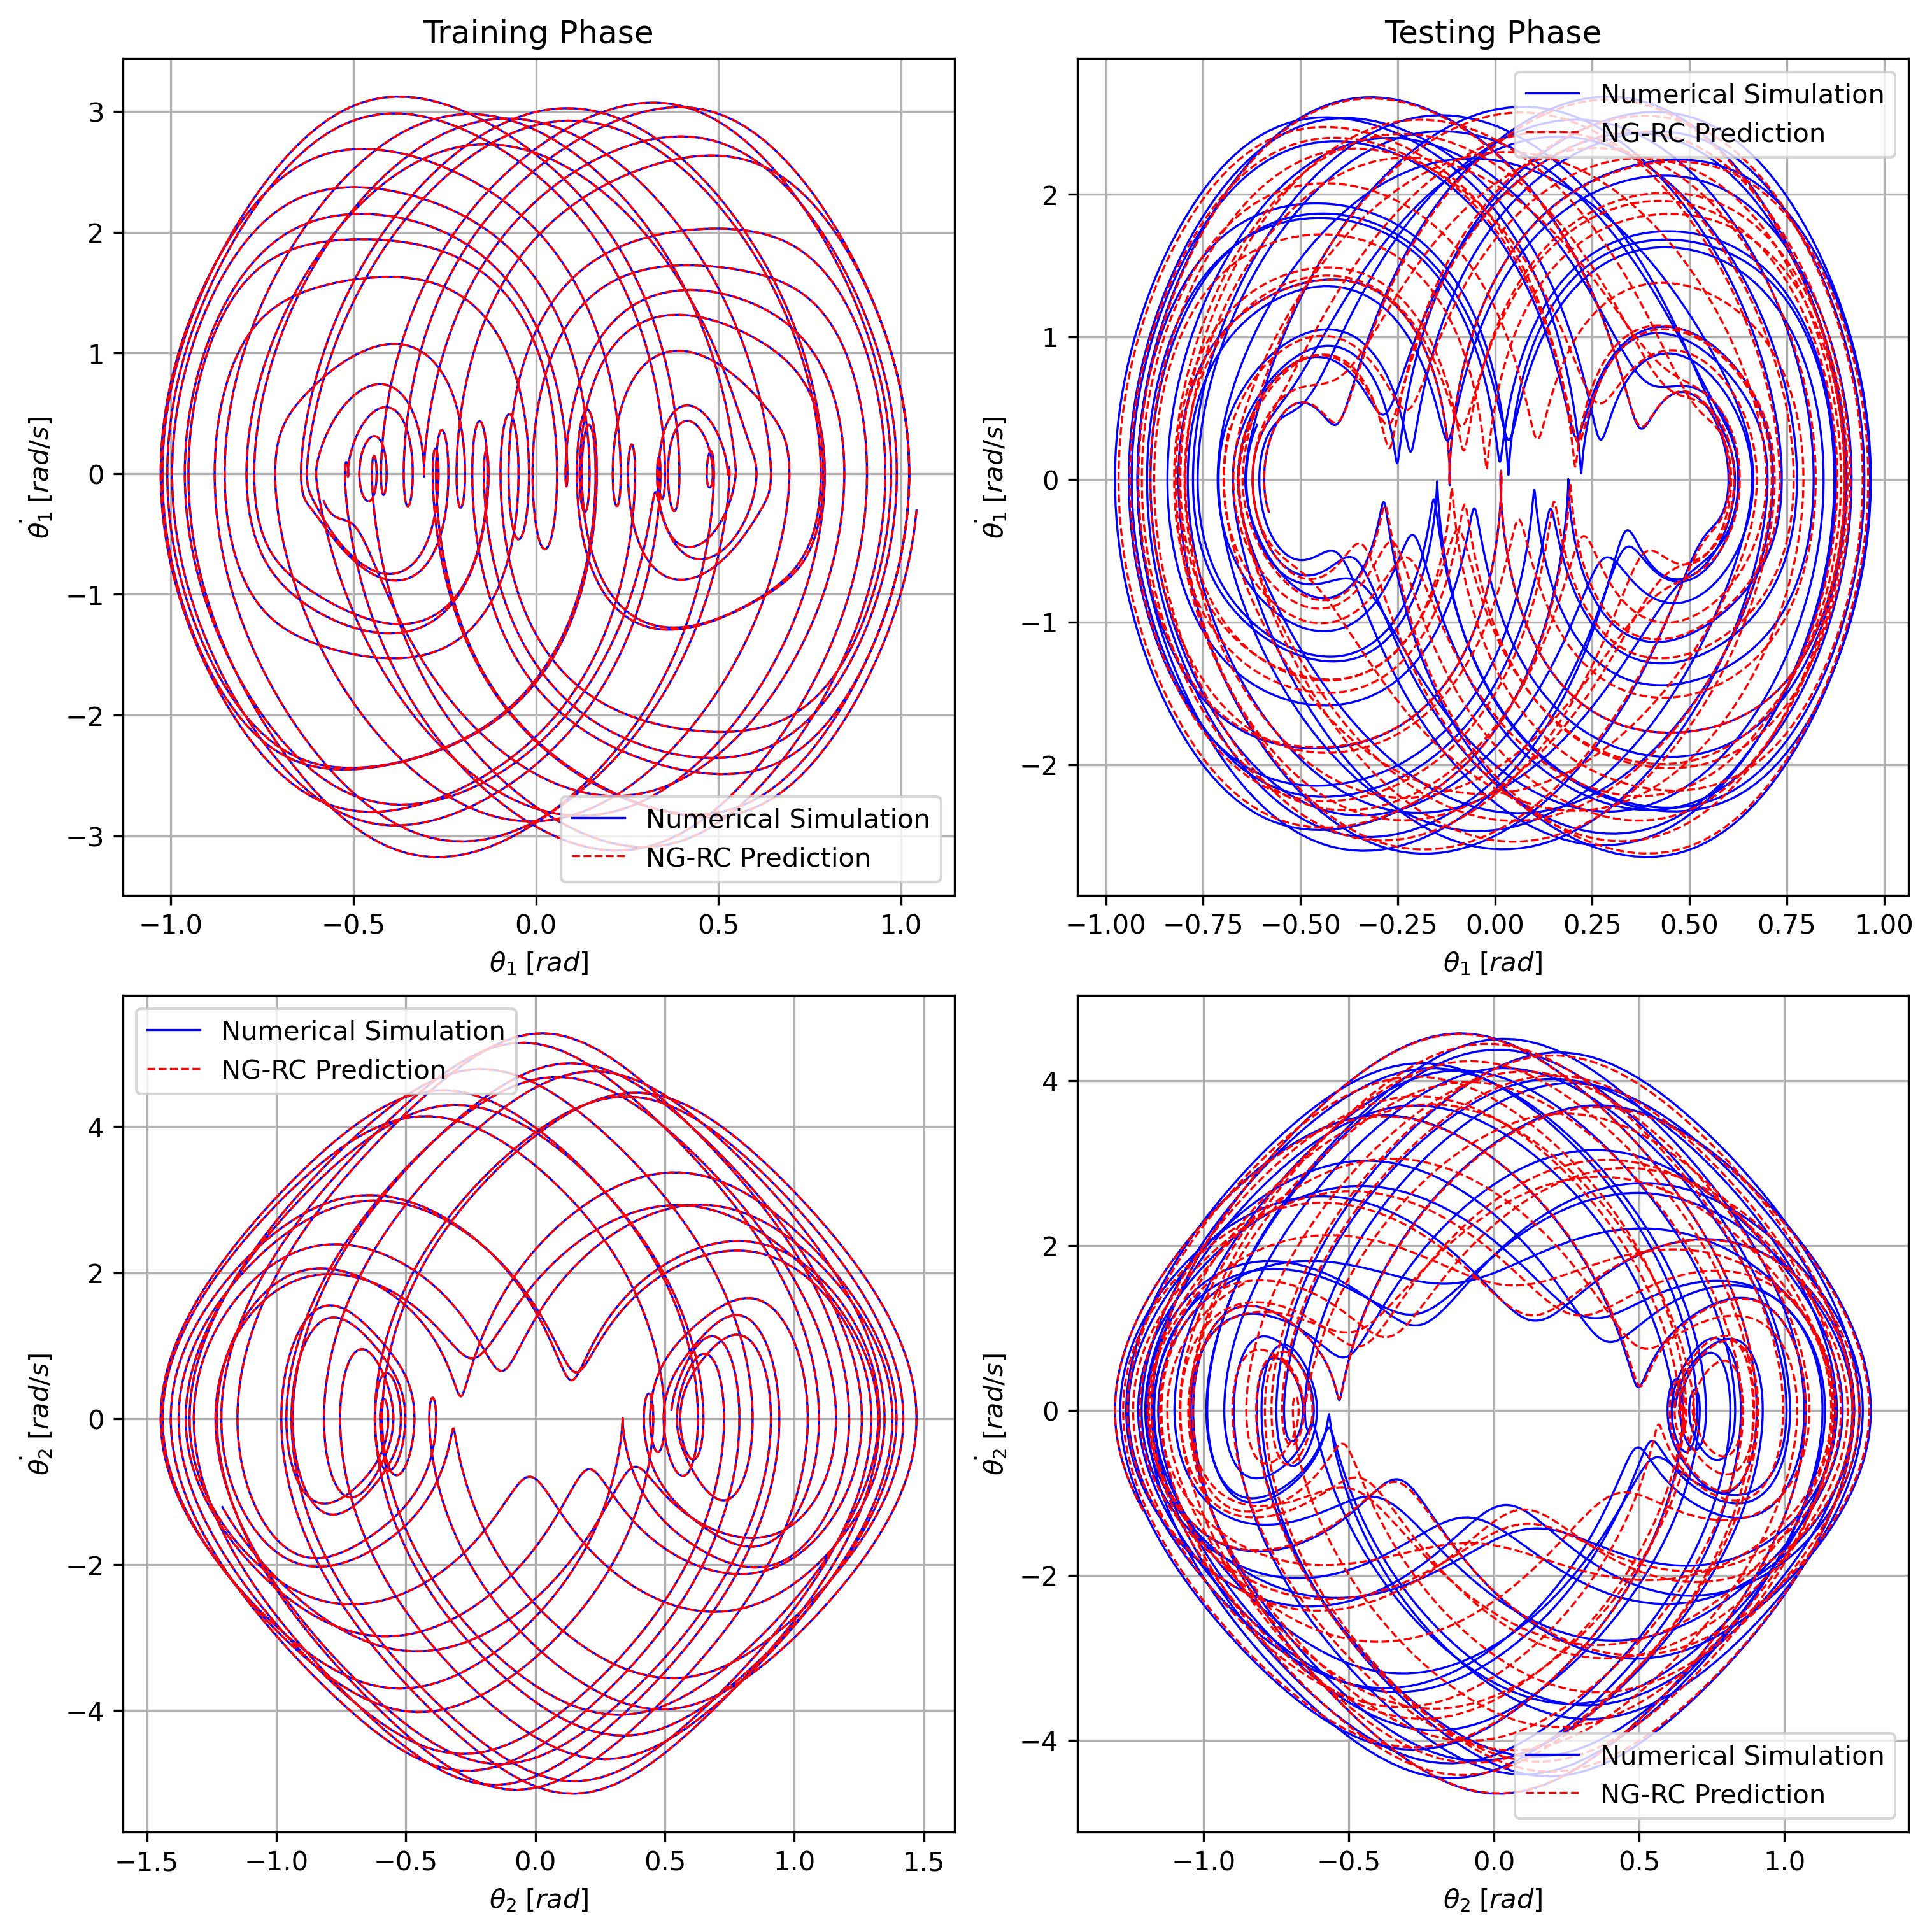

In [10]:
labels_full = [r"$\theta_1 \; [rad]$", r"$\dot{\theta_1} \; [rad/s]$", r"$\theta_2 \; [rad]$", r"$\dot{\theta_2} \; [rad/s]$"]
plot_comparison = plot_comparison(y_true_train, y_pred_train, t_train,
                           y_true_test, y_pred_test, t_test, labels_full)

labels_scatter = [labels_full[0], labels_full[2]]
properties_scatter_idx = [0, 2]
plot_scatter_comparison = plot_scatter_comparison(y_true_train, y_pred_train,
                           y_true_test, y_pred_test, properties_scatter_idx, labels_scatter)

labels_phase = [
    [labels_full[0], labels_full[1]], 
    [labels_full[2], labels_full[3]]
]
properties_phase_idx = [
    [0, 1], 
    [2, 3]
]
plot_phase_comparison = plot_phase_comparison(y_true_train, y_pred_train,
                           y_true_test, y_pred_test, properties_phase_idx, labels_phase)